# Library Imports and Setup

In [2]:
# Importing essential libraries for data manipulation, visualization, and forecasting.
import numpy as np # For numerical computations
import pandas as pd # For data manipulation
import matplotlib.pyplot as plt # For data visualization
import statsmodels.api as sm # For statistical modeling and time series analysis
import plotly.express as px  # For interactive visualizations
from sklearn.metrics import mean_absolute_error, mean_squared_error  # For evaluating model performance

# Additional libraries for file handling and forecasting
import io # For handling input/output operations
from google.colab import files # For file uploads in Google Colab

# Installing sktime for advanced forecasting methods
!pip install sktime

# Importing specific forecasting models from sktime
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
# Re-importing statsmodels and AutoReg for autoregressive models
from statsmodels.tsa.ar_model import AutoReg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 10.1 MB/s eta 0:00:00


# Uploading Files

In [3]:
# Loading and inspecting the dataset for analysis
uploaded = files.upload()

Saving DUQ_hourly.csv to DUQ_hourly.csv


 # Loading the Dataset

In [4]:
# Loading the dataset into a pandas DataFrame.
# Assuming 'uploaded' contains the uploaded file with key 'DUQ_hourly.csv'.
energy_data = pd.read_csv(io.BytesIO(uploaded['DUQ_hourly.csv']))

# Displaying the first few rows of the dataset to confirm successful loading.
print(energy_data)

                   Datetime  DUQ_MW
0       2005-12-31 01:00:00  1458.0
1       2005-12-31 02:00:00  1377.0
2       2005-12-31 03:00:00  1351.0
3       2005-12-31 04:00:00  1336.0
4       2005-12-31 05:00:00  1356.0
...                     ...     ...
119063  2018-01-01 20:00:00  1962.0
119064  2018-01-01 21:00:00  1940.0
119065  2018-01-01 22:00:00  1891.0
119066  2018-01-01 23:00:00  1820.0
119067  2018-01-02 00:00:00  1721.0

[119068 rows x 2 columns]


# Feature Engineering for Time-Based Attributes

In [5]:
# Converting the 'Datetime' column to datetime format for easy manipulation.
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])

# Extracting time-based features to enhance the dataset for forecasting.
energy_data['Weekday'] = energy_data['Datetime'].dt.dayofweek # Day of the week (0=Monday, 6=Sunday)
energy_data['Is_Weekend'] = energy_data['Weekday'] >= 5 # Flag for weekends (True if Saturday/Sunday)

# Extracting other time components from the 'Datetime' column.
energy_data['Year'] = energy_data['Datetime'].dt.year # Year
energy_data['Time'] = energy_data['Datetime'].dt.time # Time component
energy_data['Date'] = energy_data['Datetime'].dt.date # Date component
energy_data['Month'] = energy_data['Datetime'].dt.month # Month (1-12)
energy_data['Day'] = energy_data['Datetime'].dt.day  # Day of the month
energy_data['Hour'] = energy_data['Datetime'].dt.hour # Hour of the day

# Displaying the first 25 rows to confirm the new columns were added correctly.
print(energy_data.head(25))

              Datetime  DUQ_MW  Weekday  Is_Weekend  Year      Time  \
0  2005-12-31 01:00:00  1458.0        5        True  2005  01:00:00   
1  2005-12-31 02:00:00  1377.0        5        True  2005  02:00:00   
2  2005-12-31 03:00:00  1351.0        5        True  2005  03:00:00   
3  2005-12-31 04:00:00  1336.0        5        True  2005  04:00:00   
4  2005-12-31 05:00:00  1356.0        5        True  2005  05:00:00   
5  2005-12-31 06:00:00  1372.0        5        True  2005  06:00:00   
6  2005-12-31 07:00:00  1402.0        5        True  2005  07:00:00   
7  2005-12-31 08:00:00  1425.0        5        True  2005  08:00:00   
8  2005-12-31 09:00:00  1502.0        5        True  2005  09:00:00   
9  2005-12-31 10:00:00  1556.0        5        True  2005  10:00:00   
10 2005-12-31 11:00:00  1603.0        5        True  2005  11:00:00   
11 2005-12-31 12:00:00  1615.0        5        True  2005  12:00:00   
12 2005-12-31 13:00:00  1617.0        5        True  2005  13:00:00   
13 200

In [6]:
# Displaying the first 5 rows of the DataFrame to verify the dataset structure.
energy_data.head()

Datetime  DUQ_MW  Weekday  Is_Weekend  Year      Time  \
0 2005-12-31 01:00:00  1458.0        5        True  2005  01:00:00   
1 2005-12-31 02:00:00  1377.0        5        True  2005  02:00:00   
2 2005-12-31 03:00:00  1351.0        5        True  2005  03:00:00   
3 2005-12-31 04:00:00  1336.0        5        True  2005  04:00:00   
4 2005-12-31 05:00:00  1356.0        5        True  2005  05:00:00   

         Date  Month  Day  Hour  
0  2005-12-31     12   31     1  
1  2005-12-31     12   31     2  
2  2005-12-31     12   31     3  
3  2005-12-31     12   31     4  
4  2005-12-31     12   31     5

In [7]:
# Checking the dimensions of the DataFrame (number of rows and columns).
energy_data.shape

(119068, 10)

In [8]:
# Displaying a concise summary of the DataFrame, including data types and non-null counts.
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119068 entries, 0 to 119067
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Datetime    119068 non-null  datetime64[ns]
 1   DUQ_MW      119068 non-null  float64       
 2   Weekday     119068 non-null  int32         
 3   Is_Weekend  119068 non-null  bool          
 4   Year        119068 non-null  int32         
 5   Time        119068 non-null  object        
 6   Date        119068 non-null  object        
 7   Month       119068 non-null  int32         
 8   Day         119068 non-null  int32         
 9   Hour        119068 non-null  int32         
dtypes: bool(1), datetime64[ns](1), float64(1), int32(5), object(2)
memory usage: 6.0+ MB


In [9]:
# Displaying the last 30 rows of the DataFrame to inspect recent data entries.
energy_data.tail(30)

Datetime  DUQ_MW  Weekday  Is_Weekend  Year      Time  \
119038 2018-01-02 19:00:00  2096.0        1       False  2018  19:00:00   
119039 2018-01-02 20:00:00  2070.0        1       False  2018  20:00:00   
119040 2018-01-02 21:00:00  2048.0        1       False  2018  21:00:00   
119041 2018-01-02 22:00:00  1988.0        1       False  2018  22:00:00   
119042 2018-01-02 23:00:00  1889.0        1       False  2018  23:00:00   
119043 2018-01-03 00:00:00  1781.0        2       False  2018  00:00:00   
119044 2018-01-01 01:00:00  1704.0        0       False  2018  01:00:00   
119045 2018-01-01 02:00:00  1663.0        0       False  2018  02:00:00   
119046 2018-01-01 03:00:00  1633.0        0       False  2018  03:00:00   
119047 2018-01-01 04:00:00  1619.0        0       False  2018  04:00:00   
119048 2018-01-01 05:00:00  1623.0        0       False  2018  05:00:00   
119049 2018-01-01 06:00:00  1649.0        0       False  2018  06:00:00   
119050 2018-01-01 07:00:00  1675.0        0       False  2018  07:00:00   
119051 2018-01-01 08:00:00  1682.0        0       False  2018  08:00:00   
119052 2018-01-01 09:00:00  1698.0        0       False  2018  09:00:00   
119053 2018-01-01 10:00:00  1731.0        0       False  2018  10:00:00   
119054 2018-01-01 11:00:00  1743.0        0       False  2018  11:00:00   
119055 2018-01-01 12:00:00  1764.0        0       False  2018  12:00:00   
119056 2018-01-01 13:00:00  1784.0        0       False  2018  13:00:00   
119057 2018-01-01 14:00:00  1803.0        0       False  2018  14:00:00   
119058 2018-01-01 15:00:00  1811.0        0       False  2018  15:00:00   
119059 2018-01-01 16:00:00  1828.0        0       False  2018  16:00:00   
119060 2018-01-01 17:00:00  1858.0        0       False  2018  17:00:00   
119061 2018-01-01 18:00:00  1960.0        0       False  2018  18:00:00   
119062 2018-01-01 19:00:00  1968.0        0       False  2018  19:00:00   
119063 2018-01-01 20:00:00  1962.0        0       False  2018  20:00:00   
119064 2018-01-01 21:00:00  1940.0        0       False  2018  21:00:00   
119065 2018-01-01 22:00:00  1891.0        0       False  2018  22:00:00   
119066 2018-01-01 23:00:00  1820.0        0       False  2018  23:00:00   
119067 2018-01-02 00:00:00  1721.0        1       False  2018  00:00:00   

              Date  Month  Day  Hour  
119038  2018-01-02      1    2    19  
119039  2018-01-02      1    2    20  
119040  2018-01-02      1    2    21  
119041  2018-01-02      1    2    22  
119042  2018-01-02      1    2    23  
119043  2018-01-03      1    3     0  
119044  2018-01-01      1    1     1  
119045  2018-01-01      1    1     2  
119046  2018-01-01      1    1     3  
119047  2018-01-01      1    1     4  
119048  2018-01-01      1    1     5  
119049  2018-01-01      1    1     6  
119050  2018-01-01      1    1     7  
119051  2018-01-01      1    1     8  
119052  2018-01-01      1    1     9  
119053  2018-01-01      1    1    10  
119054  2018-01-01      1    1    11  
119055  2018-01-01      1    1    12  
119056  2018-01-01      1    1    13  
119057  2018-01-01      1    1    14  
119058  2018-01-01      1    1    15  
119059  2018-01-01      1    1    16  
119060  2018-01-01      1    1    17  
119061  2018-01-01      1    1    18  
119062  2018-01-01      1    1    19  
119063  2018-01-01      1    1    20  
119064  2018-01-01      1    1    21  
119065  2018-01-01      1    1    22  
119066  2018-01-01      1    1    23  
119067  2018-01-02      1    2     0

In [10]:
# Checking for and handling any missing values in the dataset
print(energy_data.isnull().sum())

Datetime      0
DUQ_MW        0
Weekday       0
Is_Weekend    0
Year          0
Time          0
Date          0
Month         0
Day           0
Hour          0
dtype: int64


In [11]:
# Generating summary statistics for numerical columns in the DataFrame.
energy_data.describe()

Datetime         DUQ_MW        Weekday  \
count                         119068  119068.000000  119068.000000   
mean   2011-10-18 03:17:46.200826368    1658.820296       2.999303   
min              2005-01-01 01:00:00    1014.000000       0.000000   
25%              2008-05-25 14:45:00    1444.000000       1.000000   
50%              2011-10-18 04:30:00    1630.000000       3.000000   
75%              2015-03-11 17:15:00    1819.000000       5.000000   
max              2018-08-03 00:00:00    3054.000000       6.000000   
std                              NaN     301.740640       1.999960   

                Year          Month            Day           Hour  
count  119068.000000  119068.000000  119068.000000  119068.000000  
mean     2011.302911       6.416989      15.721117      11.501495  
min      2005.000000       1.000000       1.000000       0.000000  
25%      2008.000000       3.000000       8.000000       6.000000  
50%      2011.000000       6.000000      16.000000      12.000000  
75%      2015.000000       9.000000      23.000000      18.000000  
max      2018.000000      12.000000      31.000000      23.000000  
std         3.926464       3.436416       8.801321       6.921829

# Visualizing ACF and PACF Patterns

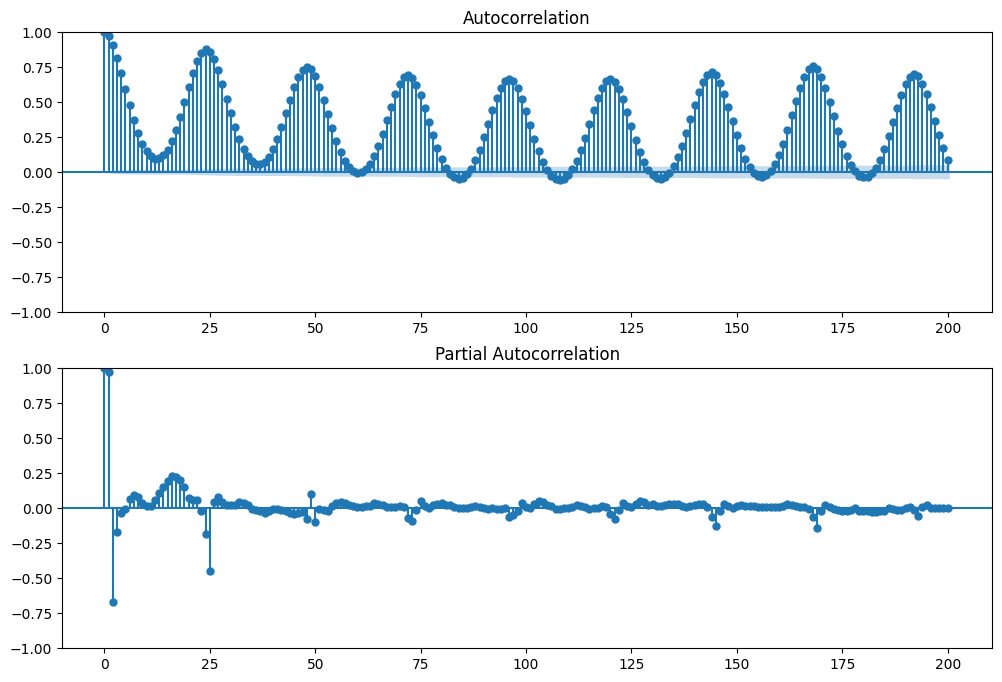

In [12]:
# Creating a figure to plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).
fig = plt.figure(figsize=(12, 8))

# Plotting the ACF to observe correlation between the series and its lags.
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(energy_data['DUQ_MW'], lags=200, ax=ax1, alpha=0.05)

# Plotting the PACF to observe partial correlations between the series and its lags.
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(energy_data['DUQ_MW'], lags=200, ax=ax2, alpha=0.05)

# Interactive Slider Plot for Time-Series Data

In [13]:
# Creating an interactive line plot to visualize energy consumption over time.
fig = px.line(energy_data,
              x='Datetime', # X-axis: Datetime column
              y='DUQ_MW', # Y-axis: Energy consumption values
              title='Energy Consumption with Interactive Slider') # Plot title

# Adding an interactive range slider and buttons for zooming into specific time ranges.
fig.update_xaxes(
    rangeslider_visible=True, # Show the range slider below the plot
    rangeselector=dict( # Add preset range selection buttons
        buttons=[
            dict(count=1, label='1y', step='year', stepmode='backward'), # Zoom to 1 year
            dict(count=2, label='2y', step='year', stepmode='backward'), # Zoom to 2 years
            dict(count=3, label='3y', step='year', stepmode='backward'), # Zoom to 3 years
            dict(step='all') # View all data
        ]
    )
)

# Displaying the interactive plot.
fig.show()

## *The slider plot reveals a seasonal pattern in energy consumption, which is further investigated using a boxplot to analyze the distribution of energy usage across months*.

# Identifying Seasonality in Energy Consumption

<Figure size 1600x600 with 0 Axes>

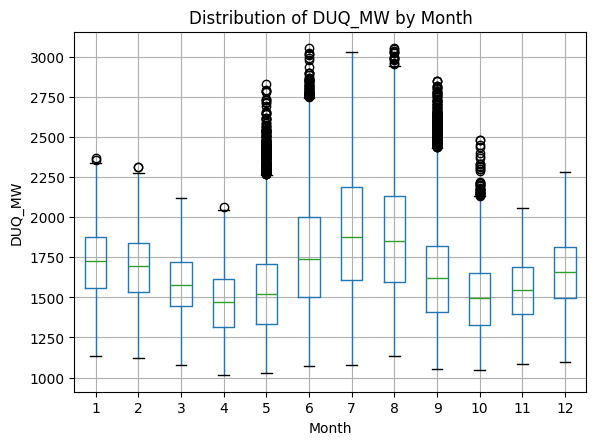

In [15]:
# Creating a boxplot to identify seasonal variations in energy consumption by month.
plt.figure(figsize=(16, 6)) # Setting the figure size for better visualization

# Boxplot groups energy consumption ('DUQ_MW') by month to highlight seasonal patterns.
energy_data.boxplot(column='DUQ_MW', by='Month')

# Adding plot titles and axis labels for clarity.
plt.title('Distribution of DUQ_MW by Month') # Main title
plt.suptitle('') # Removing the default subtitle added by boxplot
plt.xlabel('Month') # Label for the x-axis
plt.ylabel('DUQ_MW') # Label for the y-axis

# Displaying the plot.
plt.show()


##*To analyze time-series data effectively, it is essential to ensure that the dataset meets the assumptions of stationarity. The following are the key characteristics of a stationary time series*##


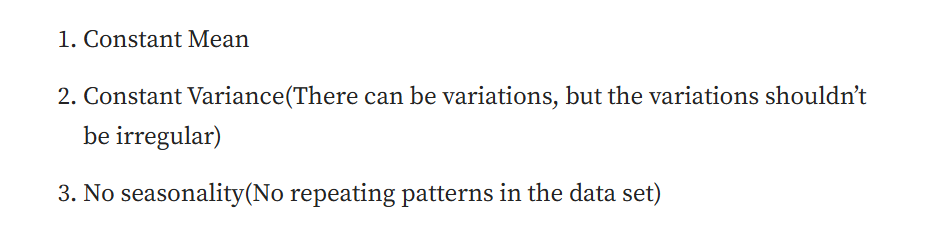


In [18]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller (ADF) test on a given dataset.
def ad_test(dataset):
     dftest = adfuller(dataset, autolag='AIC') # Perform ADF test with automatic lag selection

     # Displaying test results
     print("1. Test Statistic : ", dftest[0]) # Test statistic value
     print("2. P-Value : ", dftest[1]) # P-value for the test
     print("3. Lag_count : ", dftest[2]) # Number of lags used in the test
     print("4. Regression_Observation_Count: ", dftest[3]) # Number of observations used for regression

     # Displaying critical values for different significance levels
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print(f"\t{key}: {val}")

# Example usage of the ADF test to check the stationarity of the 'DUQ_MW' column in the dataset.
ad_test(energy_data['DUQ_MW'])

1. Test Statistic :  -17.78621872840024
2. P-Value :  3.2614963689993695e-30
3. Lag_count :  71
4. Regression_Observation_Count:  118996
5. Critical Values :
	1%: -3.4304049551335267
	5%: -2.861564289350767
	10%: -2.5667829283640278


## *The Augmented Dickey-Fuller (ADF) Test checks if a time series is stationary, a key requirement for many forecasting models. Below are the hypotheses and interpretation criteria*.


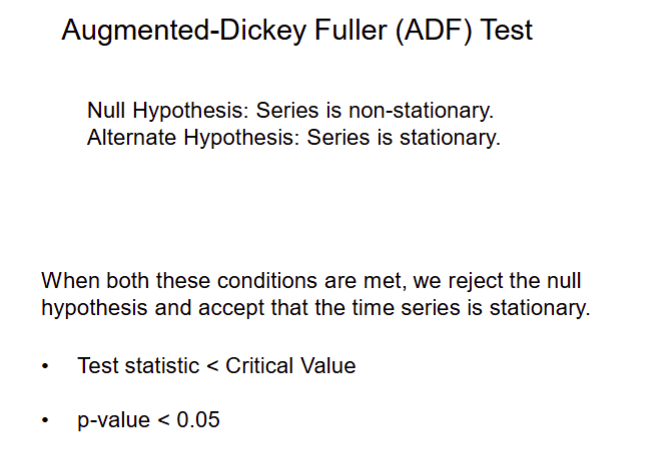

# Identifying Maximum Value and Its Timestamp

In [19]:
# Finding the maximum value in the 'DUQ_MW' column.
maximum_val = energy_data['DUQ_MW'].max()

# Identifying the timestamp corresponding to the maximum value.
maximum_datetime = energy_data.loc[energy_data['DUQ_MW'] == maximum_val, 'Datetime'].iloc[0]

# Displaying the maximum value and its corresponding timestamp.
print(f"Maximum val: {maximum_val}") # Prints the maximum energy consumption value
print(f"Corresponding timestamp: {maximum_datetime}") # Prints the timestamp of the maximum value

Maximum val: 3054.0
Corresponding timestamp: 2012-06-29 14:00:00


# Plotting Energy Consumption for a Specific Day

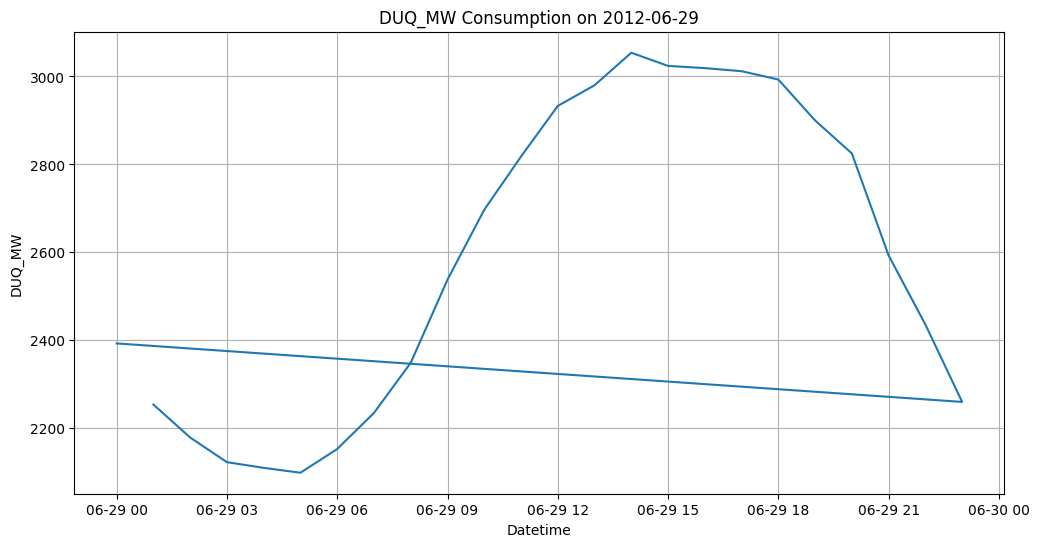

In [20]:
# Ensuring 'Datetime' column is in datetime format for filtering.
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])

# Filtering data for the specific date to be plotted.
date_to_plot = '2012-06-29' # Specify the date of interest.
energy_data_date = energy_data[energy_data['Datetime'].dt.date == pd.to_datetime(date_to_plot).date()]

# Creating a line plot of energy consumption for the specified date.
plt.figure(figsize=(12, 6)) # Setting figure size for better visualization
plt.plot(energy_data_date['Datetime'], energy_data_date['DUQ_MW']) # Plotting energy consumption over time
plt.xlabel('Datetime') # Label for the x-axis
plt.ylabel('DUQ_MW')  # Label for the y-axis
plt.title(f'DUQ_MW Consumption on {date_to_plot}') # Title with the specific date
plt.grid(True) # Adding a grid for better readability
plt.show() # Displaying the plot

## *This analysis helps understand how daily energy consumption trends vary across seasons. For instance, summer trends often show higher peaks due to cooling demands, whereas winter trends differ due to heating needs.*

# Preparing Data for Training and Testing Naive Forecaster

In [21]:
from sklearn.metrics import mean_absolute_error,mean_squared_error # For model evaluation metrics

# Loading the dataset and parsing the 'Datetime' column as datetime.
energy_data = pd.read_csv('DUQ_hourly.csv') # Replace with the correct file path
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']) # Converting 'Datetime' to datetime format

# Setting 'Datetime' as the index and sorting the dataset for time-series analysis.
energy_data = energy_data.set_index('Datetime').sort_index()

# Splitting the data: selecting the last 72 hours for training and testing.
last_72_hr = energy_data.tail(72) # Subsetting the last 72 hours

# Separating into training and testing datasets (last 24 hours for testing).
training_set = last_72_hr.iloc[:-24] # Training set: all but the last 24 hours
testing_set = last_72_hr.iloc[-24:] # Testing set: last 24 hours

# Setting the frequency of the time series to hourly ('h') for proper modeling.
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')


# Generating Naive Forecast

In [22]:
# Retrieving the most recent value from the training set to use as the naive forecast.
latesting_set_val = training_set['DUQ_MW'].iloc[-1] # Last value in the training set

# Creating a naive forecast by repeating the most recent value for the next 24 time steps.
forecast_naive = pd.Series([latesting_set_val] * 24, index=testing_set.index) # Aligning forecast with the testing set index

# Printing the naive forecast values.
print(forecast_naive)

Datetime
2018-08-02 01:00:00    1580.0
2018-08-02 02:00:00    1580.0
2018-08-02 03:00:00    1580.0
2018-08-02 04:00:00    1580.0
2018-08-02 05:00:00    1580.0
2018-08-02 06:00:00    1580.0
2018-08-02 07:00:00    1580.0
2018-08-02 08:00:00    1580.0
2018-08-02 09:00:00    1580.0
2018-08-02 10:00:00    1580.0
2018-08-02 11:00:00    1580.0
2018-08-02 12:00:00    1580.0
2018-08-02 13:00:00    1580.0
2018-08-02 14:00:00    1580.0
2018-08-02 15:00:00    1580.0
2018-08-02 16:00:00    1580.0
2018-08-02 17:00:00    1580.0
2018-08-02 18:00:00    1580.0
2018-08-02 19:00:00    1580.0
2018-08-02 20:00:00    1580.0
2018-08-02 21:00:00    1580.0
2018-08-02 22:00:00    1580.0
2018-08-02 23:00:00    1580.0
2018-08-03 00:00:00    1580.0
Freq: h, dtype: float64


# Evaluating the Naive Forecast Model

In [23]:
# Calculating the Mean Absolute Error (MAE) between the actual and forecasted values.
mae = mean_absolute_error(testing_set['DUQ_MW'], forecast_naive)

# Calculating the Root Mean Squared Error (RMSE) for the naive forecast.
rmse = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], forecast_naive))

# Printing the evaluation metrics for the naive forecast.
print(f"Mean Absolute Error (naive forecaster): {mae:.2f}") # Displays how far the forecasted values are from actuals, on average
print(f"Root Mean Squared Error (naive forecaster): {rmse:.2f}") # Displays the magnitude of error considering squared deviations

Mean Absolute Error (naive forecaster): 260.46
Root Mean Squared Error (naive forecaster): 293.03


# Visualizing Actual vs Naive Forecast

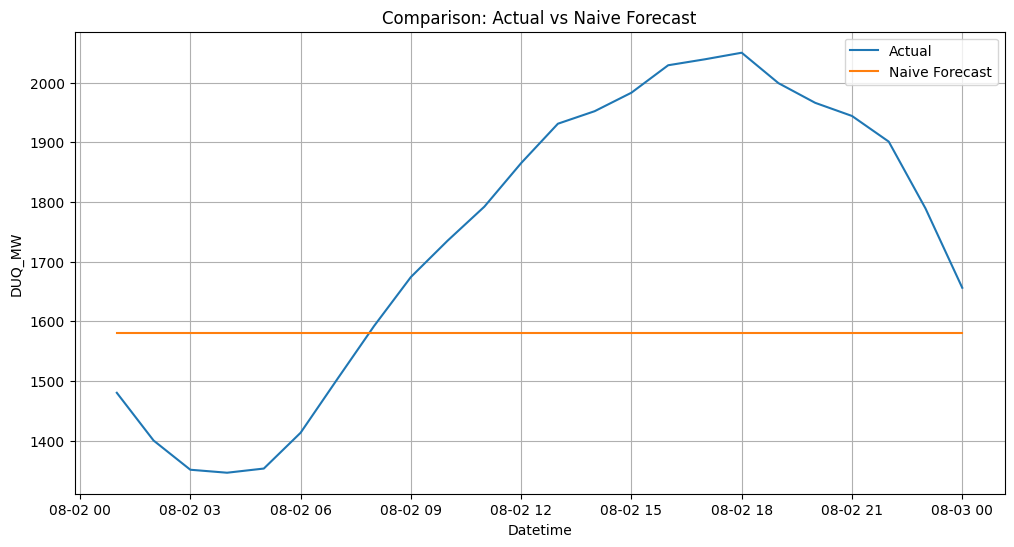

In [24]:
# Creating a plot to visualize the comparison between the actual values and the naive forecast.
plt.figure(figsize=(12, 6)) # Setting the figure size for better readability

# Plotting the actual values from the testing set.
plt.plot(testing_set['DUQ_MW'], label='Actual') # Actual energy consumption

# Plotting the naive forecast values.
plt.plot(forecast_naive, label='Naive Forecast') # Naive forecast for comparison

# Adding labels and title for clarity.
plt.xlabel('Datetime') # Label for the x-axis
plt.ylabel('DUQ_MW') # Label for the y-axis
plt.title('Comparison: Actual vs Naive Forecast') # Title for the plot

# Adding a legend and grid for better interpretation.
plt.legend()  # Displaying labels for the two lines
plt.grid(True) # Adding grid lines for easier visualization of trends

# Displaying the plot.
plt.show()

## *The naive forecast model imputes the last observed value as a constant for all future predictions*.

# Comparing Forecast Models: SES vs Holt-Winters

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




Mean Absolute Error (hw_model forecaster): 27.91
Root Mean Squared Error (hw_model forecaster): 38.58
Mean Absolute Error (ses_model forecaster): 47.35
Root Mean Squared Error (ses_model forecaster): 59.60


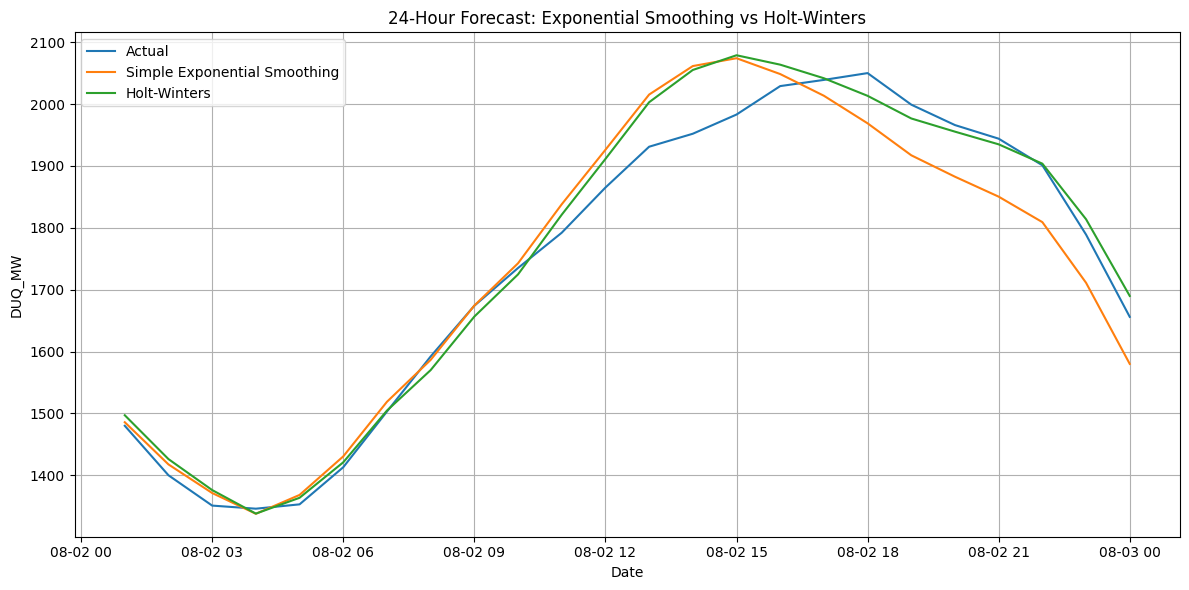

In [25]:
# Load and prepare the dataset
energy_data = pd.read_csv('DUQ_hourly.csv') # Load dataset
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])  # Convert 'Datetime' column to datetime format
energy_data = energy_data.set_index('Datetime').sort_index() # Set 'Datetime' as index and sort


# Doing training_set testing_set split and frequency setting
last_72_hrsmooth = energy_data.tail(72)

training_set = last_72_hrsmooth.iloc[:-24]
testing_set = last_72_hrsmooth.iloc[-24:]

#set the frequency to hourly
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')

# Prepare the forecast horizon
fh = np.arange(1, 25) # Forecast horizon for 24 hours

# Simple Exponential Smoothing Model with additive
ses_model = ExponentialSmoothing(seasonal="add", sp=24) # Specify seasonal periodicity
ses_model.fit(training_set['DUQ_MW']) # Fit SES model
ses_forecast = ses_model.predict(fh) # Generate SES forecasts

# Holt-Winters Model using AutoETS
hw_model = AutoETS(auto=True, sp=24, n_jobs=-1) # Enable auto-selection of ETS parameters
hw_model.fit(training_set['DUQ_MW']) # Fit Holt-Winters model
hw_forecast = hw_model.predict(fh) # Generate Holt-Winters forecasts


# model eval
mae_hw = mean_absolute_error(testing_set['DUQ_MW'], hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], hw_forecast))
mae_ses = mean_absolute_error(testing_set['DUQ_MW'], ses_forecast)
rmse_ses = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], ses_forecast))
print(f"Mean Absolute Error (hw_model forecaster): {mae_hw:.2f}")
print(f"Root Mean Squared Error (hw_model forecaster): {rmse_hw:.2f}")
print(f"Mean Absolute Error (ses_model forecaster): {mae_ses:.2f}")
print(f"Root Mean Squared Error (ses_model forecaster): {rmse_ses:.2f}")


# Plot comparison of actual values with SES and Holt-Winters forecasts
plt.figure(figsize=(12, 6))
plt.plot(testing_set['DUQ_MW'], label='Actual') # Actual values
plt.plot(ses_forecast.index, ses_forecast, label='Simple Exponential Smoothing') # SES forecasts
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters') # Holt-Winters forecasts
plt.title('24-Hour Forecast: Exponential Smoothing vs Holt-Winters') # Add a descriptive title
plt.xlabel('Date')
plt.ylabel('DUQ_MW')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# AutoRegressive (AR(1)) Model for Time-Series Forecasting

Mean Absolute Error (AR(1)): 200.42
Root Mean Squared Error (AR(1)): 221.98


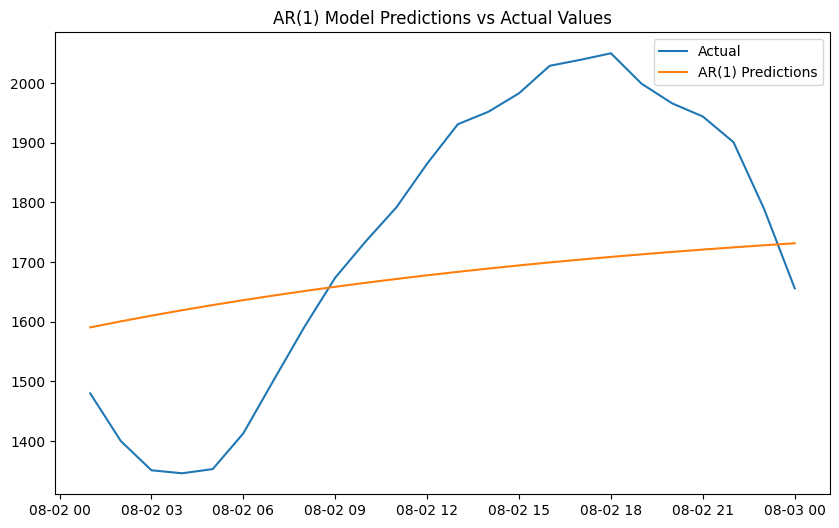

In [26]:
# Importing the necessary modules for autoregressive modeling
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

# Load and prepare the dataset
energy_data = pd.read_csv('DUQ_hourly.csv') # Load the dataset
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']) # Convert 'Datetime' column to datetime format
energy_data = energy_data.set_index('Datetime').sort_index() # Set 'Datetime' as index and sort

# Splitting data: selecting the last 72 hours for AR(1) modeling
last_72_hrar = energy_data.tail(72) # Subset last 72 hours
training_set = last_72_hrar.iloc[:-24] # Training set: all but last 24 hours
testing_set = last_72_hrar.iloc[-24:] # Testing set: last 24 hours

# forecast horizon
fh = np.arange(1, 25)

# Setting the frequency to hourly for time-series analysis
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')

# Fitting an AR(1) model to the training set
model_ar = AutoReg(training_set['DUQ_MW'], lags=1) # Autoregressive model with 1 lag
model_fit_ar = model_ar.fit()

# Generating predictions for the testing set
predictions_ar = model_fit_ar.predict(start=len(training_set), end=len(training_set) + len(testing_set) - 1)

# Evaluating the AR(1) model using MAE and RMSE
mae = mean_absolute_error(testing_set['DUQ_MW'], predictions_ar) # Mean Absolute Error
rmse = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], predictions_ar)) # Root Mean Squared Error

print(f"Mean Absolute Error (AR(1)): {mae:.2f}")
print(f"Root Mean Squared Error (AR(1)): {rmse:.2f}")


# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6)) # Set figure size
plt.plot(testing_set['DUQ_MW'], label='Actual') # Plot actual values
plt.plot(predictions_ar, label='AR(1) Predictions') # Plot AR(1) model predictions
plt.legend() # Add legend
plt.title('AR(1) Model Predictions vs Actual Values') # Add title
plt.show() # Display the plot


# Moving Average (MA(1)) Model for Time-Series Forecasting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Mean Absolute Error (MA(1)): 200.42
Root Mean Squared Error (MA(1)): 221.98


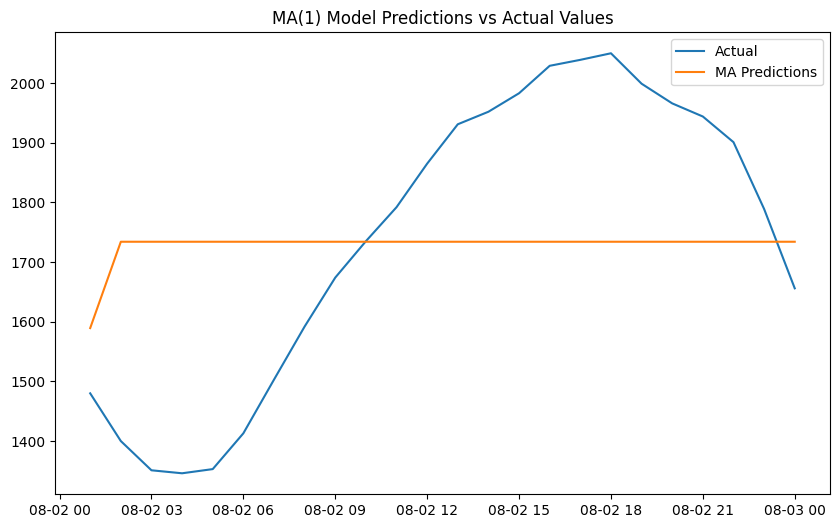

In [27]:
# Load and prepare the dataset
energy_data = pd.read_csv('DUQ_hourly.csv') # Load the dataset
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']) # Convert 'Datetime' column to datetime format
energy_data = energy_data.set_index('Datetime').sort_index() # Set 'Datetime' as index and sort for time-series analysis

# Selecting the last 72 hours of data
last_72_hours = energy_data.tail(72)

# Splitting data into training and testing sets
training_set = last_72_hours.iloc[:-24] # Training set: all but the last 24 hours
testing_set = last_72_hours.iloc[-24:] # Testing set: last 24 hours

# forecasting horizon
fh = np.arange(1, 25)

# Setting frequency to hourly for time-series compatibility
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')

# Fitting a Moving Average (MA) model with q=1 (based on ACF plot analysis)
model_ma = sm.tsa.arima.ARIMA(training_set['DUQ_MW'], order=(0, 0, 1)) # MA(1) model
model_fit = model_ma.fit() # Fit the model

# Forecasting for the testing set
predictions_ma = model_fit.predict(start=len(training_set), end=len(training_set) + len(testing_set) - 1)

# Evaluating the MA(1) model using MAE and RMSE
mae_ma = mean_absolute_error(testing_set['DUQ_MW'], predictions_ma) # Mean Absolute Error
rmse_ma = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], predictions_ma)) # Root Mean Squared Error

print(f"Mean Absolute Error (MA(1)): {mae:.2f}")
print(f"Root Mean Squared Error (MA(1)): {rmse:.2f}")

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6)) # Set figure size
plt.plot(testing_set['DUQ_MW'], label='Actual') # Plot actual values
plt.plot(predictions_ma, label='MA Predictions') # Plot MA model predictions
plt.legend() # Add legend
plt.title('MA(1) Model Predictions vs Actual Values') # Add title
plt.show() # Display the plot

# ARIMA(1,0,1) Model for Time-Series Forecasting

Mean Absolute Error (ARIMA(1,0,1)): 241.73
Root Mean Squared Error (ARIMA(1,0,1)): 276.14


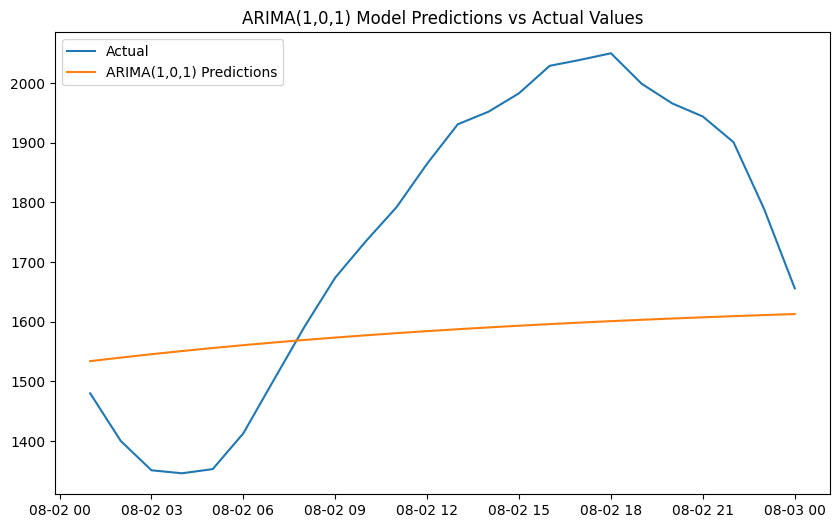

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and prepare the dataset
energy_data = pd.read_csv('DUQ_hourly.csv') # Load the dataset
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']) # Convert 'Datetime' column to datetime format
energy_data = energy_data.set_index('Datetime').sort_index() # Set 'Datetime' as index and sort

# Splitting data: selecting the last 72 hours for ARIMA modeling
last_72_hours = energy_data.tail(72) # Subset last 72 hours
training_set = last_72_hours.iloc[:-24] # Training set: all but last 24 hours
testing_set = last_72_hours.iloc[-24:] # Testing set: last 24 hours

# Setting the frequency to hourly for time-series compatibility
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')

# Fitting the ARIMA model with parameters (p=1, d=0, q=1)
model_arima = ARIMA(training_set['DUQ_MW'], order=(1,0,1)) # ARIMA(1,0,1) model
model_fit_arima = model_arima.fit() # Fit the model

# Forecasting for the testing set
predictions_arima = model_fit_arima.forecast(steps=len(testing_set)) # Forecast future values

# Evaluating the ARIMA model using MAE and RMSE
mae = mean_absolute_error(testing_set['DUQ_MW'], predictions_arima) # Mean Absolute Error
rmse = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], predictions_arima)) # Root Mean Squared Error

print(f"Mean Absolute Error (ARIMA(1,0,1)): {mae:.2f}")
print(f"Root Mean Squared Error (ARIMA(1,0,1)): {rmse:.2f}")

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6)) # Set figure size
plt.plot(testing_set.index, testing_set['DUQ_MW'], label='Actual') # Plot actual values
plt.plot(testing_set.index, predictions_arima, label='ARIMA(1,0,1) Predictions') # Plot ARIMA model predictions
plt.legend() # Add legend
plt.title('ARIMA(1,0,1) Model Predictions vs Actual Values') # Add title
plt.show() # Display the plot

# Seasonal ARIMA (SARIMA) Model for Time-Series Forecasting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Mean Absolute Error (SARIMA(1,0,1)): 38.54
Root Mean Squared Error (SARIMA(1,0,1)): 46.69


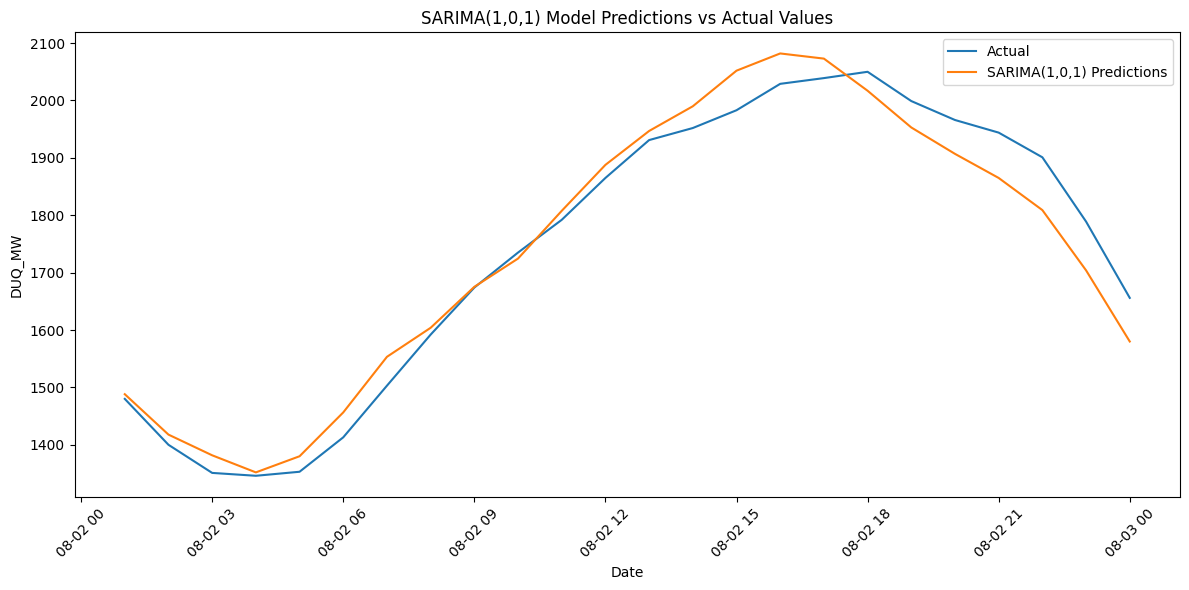

In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load and prepare the dataset
energy_data = pd.read_csv('DUQ_hourly.csv') # Load the dataset
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']) # Convert 'Datetime' to datetime format
energy_data = energy_data.set_index('Datetime').sort_index() # Set 'Datetime' as index and sort for time-series analysis

# Selecting the last 72 hours of data
last_72_hours = energy_data.tail(72)

# Splitting data into training and testing sets
training_set = last_72_hours.iloc[:-24] # Training set: all but the last 24 hours
testing_set = last_72_hours.iloc[-24:] # Testing set: last 24 hours

# Setting frequency to hourly for time-series compatibility
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')

fh = np.arange(1, 25)

# Fitting a SARIMA model with specified parameters
model_sarima = SARIMAX(training_set['DUQ_MW'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 24),
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model_sarima.fit() # Fit the SARIMA model

# Forecasting for the next 24 steps (testing period)
predictions_sarima = model_fit.forecast(steps=24)

# Evaluating the SARIMA model using MAE and RMSE
mae = mean_absolute_error(testing_set['DUQ_MW'], predictions_sarima) # Mean Absolute Error
rmse = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], predictions_sarima)) # Root Mean Squared Error

print(f"Mean Absolute Error (SARIMA(1,0,1)): {mae:.2f}")
print(f"Root Mean Squared Error (SARIMA(1,0,1)): {rmse:.2f}")

# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6)) # Set figure size
plt.plot(testing_set.index, testing_set['DUQ_MW'], label='Actual') # Plot actual values
plt.plot(testing_set.index, predictions_sarima, label='SARIMA(1,0,1) Predictions') # Plot SARIMA model predictions
plt.legend() # Add legend
plt.title('SARIMA(1,0,1) Model Predictions vs Actual Values') # Add title
plt.xlabel('Date') # Label for x-axis
plt.ylabel('DUQ_MW') # Label for y-axis
plt.xticks(rotation=45) # Rotate x-axis ticks for better readability
plt.tight_layout() # Adjust layout to prevent clipping
plt.show() # Display the plot

# SARIMA Model with Auto-ARIMA for Time-Series Forecasting

Mean Absolute Error (SARIMA(1,0,1)): 50.91
Root Mean Squared Error (SARIMA(1,0,1)): 68.80


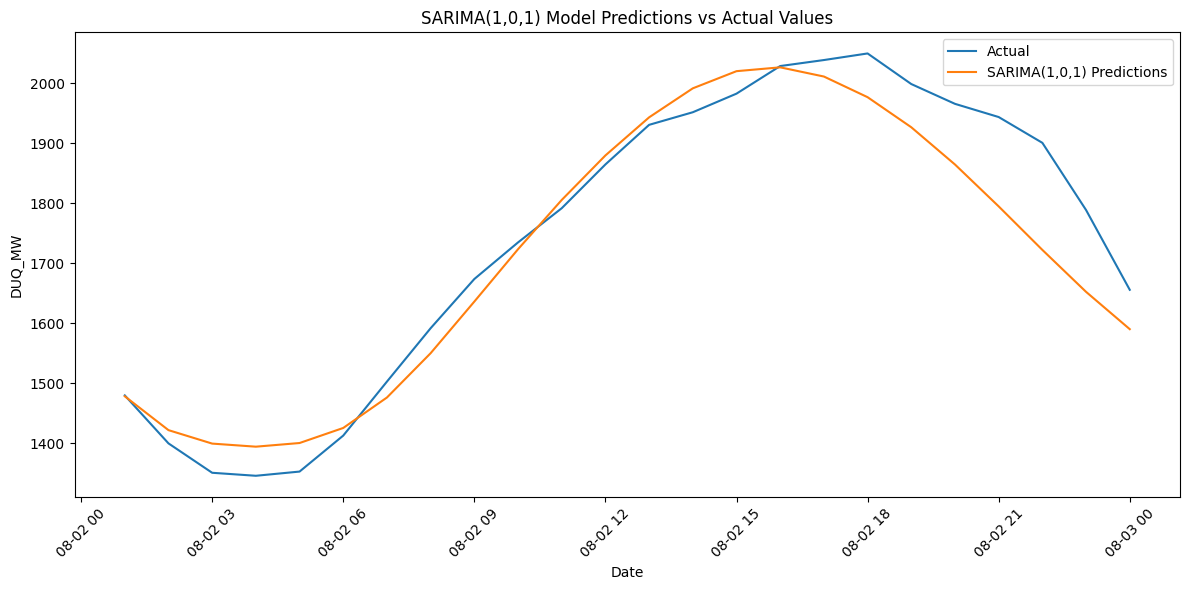

In [28]:
# Install and import pmdarima for Auto-ARIMA functionality
!pip install pmdarima
from pmdarima import auto_arima

# Load and prepare the dataset
energy_data = pd.read_csv('DUQ_hourly.csv') # Load the dataset
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']) # Convert 'Datetime' to datetime format
energy_data = energy_data.set_index('Datetime').sort_index() # Set 'Datetime' as index and sort for time-series analysis

# Selecting the last 72 hours of data for modeling
last_72_hr = energy_data.tail(72)

# Splitting data into training and testing sets
training_set = last_72_hr.iloc[:-24] # Training set: all but the last 24 hours
testing_set = last_72_hr.iloc[-24:] # Testing set: last 24 hours

# Setting frequency to hourly for compatibility with time-series analysis
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')

# Fitting a SARIMA model using Auto-ARIMA with specified parameters
model_sarimaxx = auto_arima(training_set['DUQ_MW'],
                          order=(1,0,1), # ARIMA parameters
                          seasonal_order=(1,1,1,24), # Seasonal parameters (SARIMA)
                          suppress_warnings=True, # Suppress warnings for cleaner output
                          stepwise=False, # Use non-stepwise search for better parameter tuning
                          error_action="ignore") # Ignore errors during fitting

# Generating forecasts for the next 24 time steps
predictions_sarima, _ = model_sarimaxx.predict(n_periods=24, return_conf_int=True)

# Evaluating the SARIMA model using MAE and RMSE
mae = mean_absolute_error(testing_set['DUQ_MW'], predictions_sarima) # Mean Absolute Error
rmse = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], predictions_sarima)) # Root Mean Squared Error

print(f"Mean Absolute Error (SARIMA(1,0,1)): {mae:.2f}")
print(f"Root Mean Squared Error (SARIMA(1,0,1)): {rmse:.2f}")

# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6)) # Set figure size
plt.plot(testing_set.index, testing_set['DUQ_MW'], label='Actual') # Plot actual values
plt.plot(testing_set.index, predictions_sarima, label='SARIMA(1,0,1) Predictions') # Plot SARIMA model predictions
plt.legend() # Add legend
plt.title('SARIMA(1,0,1) Model Predictions vs Actual Values') # Add title
plt.xlabel('Date') # Label for x-axis
plt.ylabel('DUQ_MW')  # Label for y-axis
plt.xticks(rotation=45) # Rotate x-axis ticks for better readability
plt.tight_layout() # Adjust layout to prevent clipping
plt.show() # Display the plot

# Data Preparation for Forecasting with Reduction Models

In [31]:
from sktime.forecasting.compose import make_reduction

# Load and prepare the dataset
energy_data = pd.read_csv('DUQ_hourly.csv') # Load the dataset
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']) # Convert 'Datetime' column to datetime format
energy_data = energy_data.set_index('Datetime').sort_index() # Set 'Datetime' as index and sort for time-series analysis

# Selecting the last 72 hours of data for forecasting
last_72_hours = energy_data.tail(72)

# Splitting the data into training (48 hours) and testing (24 hours) sets
training_set = last_72_hours.iloc[:-24] # Training set: first 48 hours
testing_set = last_72_hours.iloc[-24:] # Testing set: last 24 hours

# Setting frequency to hourly for compatibility with time-series models
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')

# Defining the forecasting horizon for 24 hours ahead
fh = np.arange(1, 25)  # Forecasting horizon (24 steps ahead)

#  Time-Series Forecasting with Linear Regression Using Reduction

In [32]:
from sktime.forecasting.compose import make_reduction
from sklearn.linear_model import LinearRegression
from sktime.forecasting.base import ForecastingHorizon



# Splitting the last 72 hours of data into training (48 hours) and testing (24 hours) sets
last_72_hours = energy_data.tail(72) # Subset of the last 72 hours
training_set = last_72_hours.iloc[:-24] # Training set: first 48 hours
testing_set = last_72_hours.iloc[-24:] # Testing set: last 24 hours

# Setting frequency to hourly for compatibility with time-series forecasting models
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')

# Defining the forecasting horizon (relative) for the next 24 steps
fh = ForecastingHorizon(np.arange(1, 25), is_relative=True)

# Creating a Linear Regression model as the base regressor
regress_lr = LinearRegression()

# Creating a recursive reduction-based forecaster with a window length of 24
forecaster_lr = make_reduction(regress_lr, window_length=24, strategy="recursive")

# Fitting the forecaster on the training data
forecaster_lr.fit(training_set)

# Generating forecasts for the defined horizon
lr_prediction = forecaster_lr.predict(fh)

# Printing the forecasted values
print(lr_prediction)

                          DUQ_MW
2018-08-02 01:00:00  1623.966273
2018-08-02 02:00:00  1616.692232
2018-08-02 03:00:00  1402.482793
2018-08-02 04:00:00  1341.241076
2018-08-02 05:00:00  1561.175109
2018-08-02 06:00:00  1528.860775
2018-08-02 07:00:00  1389.150279
2018-08-02 08:00:00  1605.884138
2018-08-02 09:00:00  1778.408929
2018-08-02 10:00:00  1534.555382
2018-08-02 11:00:00  1792.832563
2018-08-02 12:00:00  2234.906964
2018-08-02 13:00:00  1618.520843
2018-08-02 14:00:00  1472.747996
2018-08-02 15:00:00  2824.393271
2018-08-02 16:00:00  2340.650323
2018-08-02 17:00:00   639.515760
2018-08-02 18:00:00  2435.125395
2018-08-02 19:00:00  3788.131694
2018-08-02 20:00:00   214.605318
2018-08-02 21:00:00   516.844964
2018-08-02 22:00:00  5344.586013
2018-08-02 23:00:00  1255.401914
2018-08-03 00:00:00 -3326.775667


In [33]:
# Count the number of forecasted values in the Linear Regression predictions.
lr_prediction.count()

DUQ_MW    24
dtype: int64

# Evaluating Linear Regression Forecast with Model Metrics and Visualization

Mean Absolute Error (Linear Regression): 800.05
Root Mean Squared Error (Linear Regression): 1426.59


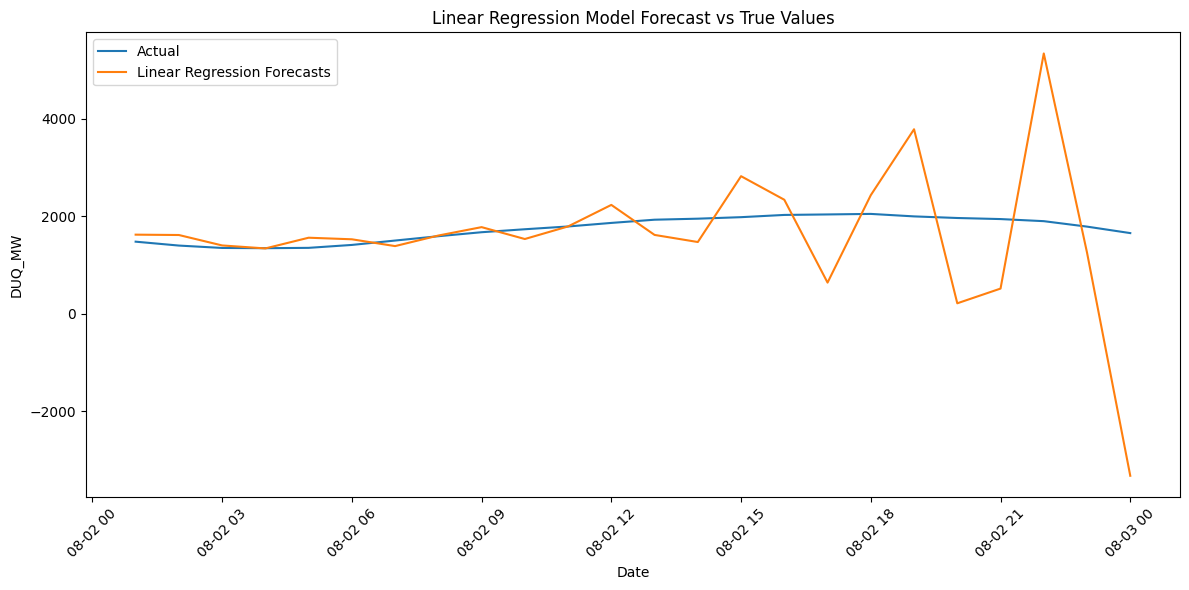

In [34]:
# Evaluate the Linear Regression model's performance
mae = mean_absolute_error(testing_set['DUQ_MW'], lr_prediction) # Calculate Mean Absolute Error
rmse = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], lr_prediction)) # Calculate Root Mean Squared Error

# Print evaluation metrics
print(f"Mean Absolute Error (Linear Regression): {mae:.2f}") # Display MAE
print(f"Root Mean Squared Error (Linear Regression): {rmse:.2f}") # Display RMSE

# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6)) # Set figure size for better readability
plt.plot(testing_set.index, testing_set['DUQ_MW'], label='Actual') # Plot actual values
plt.plot(testing_set.index, lr_prediction, label='Linear Regression Forecasts') # Plot Linear Regression forecasts
plt.legend() # Add legend to distinguish actual and forecasted values
plt.title('Linear Regression Model Forecast vs True Values') # Add title for the plot
plt.xlabel('Date') # Label for x-axis
plt.ylabel('DUQ_MW') # Label for y-axis
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent clipping

# Display the plot
plt.show()

# Moving Average (MA(1)) Model for Time-Series Forecasting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Mean Absolute Error (MA(1)): 213.58
Root Mean Squared Error (MA(1)): 241.52


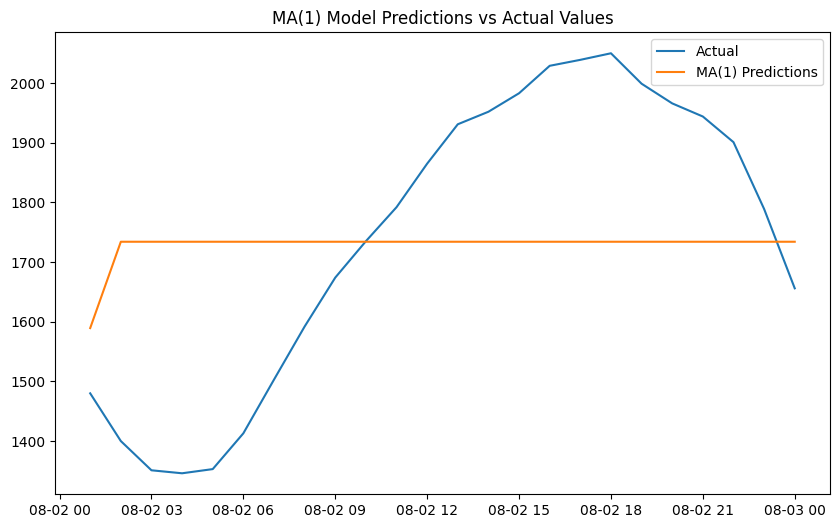

In [35]:
# Load and prepare the dataset
energy_data = pd.read_csv('DUQ_hourly.csv') # Load the dataset
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']) # Convert 'Datetime' to datetime format
energy_data = energy_data.set_index('Datetime').sort_index() # Set 'Datetime' as index and sort for time-series analysis

# Selecting the last 72 hours of data for modeling
last_72_hours = energy_data.tail(72)

# Splitting the data into training and testing sets
training_set = last_72_hours.iloc[:-24] # Training set: all but the last 24 hours
testing_set = last_72_hours.iloc[-24:] # Testing set: last 24 hours

# forecasting horizon
fh = np.arange(1, 25)

# Setting frequency to hourly for compatibility with time-series analysis
training_set = training_set.asfreq('h')
testing_set = testing_set.asfreq('h')

# Fitting a Moving Average (MA(1)) model with q=1
model = sm.tsa.arima.ARIMA(training_set['DUQ_MW'], order=(0, 0, 1)) # MA(1) model
model_fit = model.fit() # Fit the model

# Forecasting for the testing period
predictions = model_fit.predict(start=len(training_set), end=len(training_set) + len(testing_set) - 1)

# Evaluating the MA(1) model using MAE and RMSE
mae = mean_absolute_error(testing_set['DUQ_MW'], predictions) # Mean Absolute Error
rmse = np.sqrt(mean_squared_error(testing_set['DUQ_MW'], predictions)) # Root Mean Squared Error

print(f"Mean Absolute Error (MA(1)): {mae:.2f}")
print(f"Root Mean Squared Error (MA(1)): {rmse:.2f}")

# Visualizing actual vs predicted values
plt.figure(figsize=(10, 6)) # Set figure size
plt.plot(testing_set['DUQ_MW'], label='Actual') # Plot actual values
plt.plot(predictions, label='MA(1) Predictions') # Plot MA(1) model predictions
plt.legend() # Add legend
plt.title('MA(1) Model Predictions vs Actual Values') # Add title
plt.show() # Display the plot

# Cross-Validation with Expanding Window and SARIMA Model

In [36]:
# Install the required library for ARIMA modeling.
!pip install pmdarima

# Importing necessary libraries for data handling, modeling, and evaluation.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX # For SARIMA modeling
from sktime.forecasting.model_evaluation import evaluate # For cross-validation evaluation
from sktime.split import ExpandingWindowSplitter # For expanding window cross-validation

# Load and prepare the data
energy_data = pd.read_csv('DUQ_hourly.csv') # Load the dataset
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']) # Convert 'Datetime' to datetime format
energy_data = energy_data.set_index('Datetime').sort_index() # Set 'Datetime' as index and sort for time-series analysis

# Selecting the last 125 hours of data for evaluation
last_72_hours = energy_data.tail(125)

# Target variable for modeling
y = last_72_hours['DUQ_MW']

# Define the SARIMA model with specified seasonal and ARIMA terms
forecaster = ARIMA(training_set['DUQ_MW'], order=(1, 0, 1), # ARIMA parameters
                   seasonal_order=(1, 1, 1, 24), # Seasonal parameters with periodicity of 24
                   enforce_stationarity=False, # Relax stationarity constraints
                   enforce_invertibility=False # Relax invertibility constraints
)

# Fit the SARIMA model
model_fit = forecaster.fit()

# Define an expanding window cross-validation strategy
cv = ExpandingWindowSplitter(initial_window=4, # Initial training window size
                             step_length=1, # Step length for expanding the window
                             fh=np.arange(1, 25) # Forecast horizon of 24 steps
)

# Evaluate the forecaster using expanding window cross-validation
results = evaluate(forecaster=forecaster, y=y, cv=cv, strategy="refit")

# Print evaluation results
print(results)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.10/dist-packages/sktime/utils/parallel.py:92: FitFailedWarning:


                In evaluate, fitting of forecaster ARIMA failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=4.
                The score will be set to nan.
                Failed forecaster with parameters: <statsmodels.tsa.arima.model.ARIMA object at 0x7e2d19a4ac20>.
                

/usr/local/lib/python3.10/dist-packages/sktime/utils/parallel.py:92: FitFailedWarning:


                In evaluate, fitting of forecaster ARIMA failed,
                you can set error_score='raise' in

    test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                                NaN       NaN        NaN                 4   
1                                NaN       NaN        NaN                 5   
2                                NaN       NaN        NaN                 6   
3                                NaN       NaN        NaN                 7   
4                                NaN       NaN        NaN                 8   
..                               ...       ...        ...               ...   
93                               NaN       NaN        NaN                97   
94                               NaN       NaN        NaN                98   
95                               NaN       NaN        NaN                99   
96                               NaN       NaN        NaN               100   
97                               NaN       NaN        NaN               101   

   cutoff  
0     NaT  
1     NaT  
2     NaT  
3  

/usr/local/lib/python3.10/dist-packages/sktime/utils/parallel.py:92: FitFailedWarning:


                In evaluate, fitting of forecaster ARIMA failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 93-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=97.
                The score will be set to nan.
                Failed forecaster with parameters: <statsmodels.tsa.arima.model.ARIMA object at 0x7e2d19a4ac20>.
                

/usr/local/lib/python3.10/dist-packages/sktime/utils/parallel.py:92: FitFailedWarning:


                In evaluate, fitting of forecaster ARIMA failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 94-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=98.
                The score will be set

# Data Preparation for Backtesting

In [10]:
import pandas as pd
from pmdarima import auto_arima # For automatic ARIMA model selection
from skforecast.ForecasterAutoreg import ForecasterAutoreg # For autoregressive forecasting
from skforecast.model_selection import backtesting_forecaster # For backtesting forecasting models

# Load the dataset
energy_data = pd.read_csv('DUQ_hourly.csv')  # Load the energy consumption dataset

# Convert 'Datetime' column to a datetime object for proper time-series indexing
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime'])

# Set 'Datetime' as the index for time-series operations
energy_data.set_index('Datetime', inplace=True)


# Backtesting with ARIMA and Auto-ARIMA

In [20]:
# Select the last 72 hours of data for model fitting and evaluation
last_72_hours = energy_data.tail(72)

# Create a new RangeIndex to reset the index for compatibility with some models
range_index = pd.RangeIndex(start=0, stop=72, step=1)
last_72_hours.index = range_index

# Fit an Auto-ARIMA model to determine the best parameters
model_sarimaxx = auto_arima(
    y=last_72_hours['DUQ_MW'], # Target variable
    order=(1, 0, 1),  # ARIMA parameters
    seasonal_order=(1, 1, 1, 24),  # Seasonal ARIMA parameters with a periodicity of 24
    suppress_warnings=True, # Suppress warnings for cleaner output
    stepwise=True, # Use stepwise search for parameter selection
    error_action="ignore" # Ignore errors during fitting
)

from sklearn.linear_model import LinearRegression
# Define ForecasterAutoreg with a compatible regressor
forecaster = ForecasterAutoreg(
    regressor=LinearRegression(), # Base regression model
    lags=24, # Use the last 24 lags for forecasting
    transformer_y=None # No transformation applied to target variable
)

# Use auto_arima directly to fit the model
model_sarimaxx = auto_arima(
    y=last_72_hours['DUQ_MW'],
    order=(1, 0, 1),  # ARIMA parameters
    seasonal_order=(1, 1, 1, 24),  # Seasonal ARIMA parameters
    suppress_warnings=True,
    stepwise=True,
    error_action="ignore"
)

# Predict the next 24 time steps using the fitted Auto-ARIMA model
predictions_arima = model_sarimaxx.predict(n_periods=24)  # Generate predictions
print(predictions_arima)  # Display the predictions

# Define a ForecasterAutoreg using a Linear Regression model for forecasting
model_sarimaxx = auto_arima(
    y=last_72_hours['DUQ_MW'],
    order=(1, 0, 1),  # ARIMA parameters
    seasonal_order=(1, 1, 1, 24),  # Seasonal ARIMA parameters
    suppress_warnings=True,
    stepwise=True,
    error_action="ignore"
)

# Predict the next 24 time steps using the Auto-ARIMA model
predictions_arima = model_sarimaxx.predict(n_periods=24)  # Ensure n_periods is an integer
print(predictions_arima) # Display the predictions

72    1652.392235
73    1617.554677
74    1615.122307
75    1639.952598
76    1684.395905
77    1739.662450
78    1797.100666
79    1849.243717
80    1890.533744
81    1917.688413
82    1929.724533
83    1927.693424
84    1914.209177
85    1892.862922
86    1867.614681
87    1842.241753
88    1819.902363
89    1802.849142
90    1792.302720
91    1788.474142
92    1790.708367
93    1797.710737
94    1807.814499
95    1819.249399
dtype: float64
72    1652.392235
73    1617.554677
74    1615.122307
75    1639.952598
76    1684.395905
77    1739.662450
78    1797.100666
79    1849.243717
80    1890.533744
81    1917.688413
82    1929.724533
83    1927.693424
84    1914.209177
85    1892.862922
86    1867.614681
87    1842.241753
88    1819.902363
89    1802.849142
90    1792.302720
91    1788.474142
92    1790.708367
93    1797.710737
94    1807.814499
95    1819.249399
dtype: float64


In [24]:
# Generate predictions for the next 24 time steps using the SARIMA model
predictions = model_sarimaxx.predict(n_periods=24)

# Print the predictions to verify the output and ensure correctness
print(predictions)

72    1652.392235
73    1617.554677
74    1615.122307
75    1639.952598
76    1684.395905
77    1739.662450
78    1797.100666
79    1849.243717
80    1890.533744
81    1917.688413
82    1929.724533
83    1927.693424
84    1914.209177
85    1892.862922
86    1867.614681
87    1842.241753
88    1819.902363
89    1802.849142
90    1792.302720
91    1788.474142
92    1790.708367
93    1797.710737
94    1807.814499
95    1819.249399
dtype: float64


# Evaluating Forecast Accuracy

In [25]:
# Extract the actual values for the forecasted period
actual_values = energy_data['DUQ_MW'][-24:] # Select the last 24 observations as the ground truth

# Import necessary evaluation metrics and numerical functions
from sklearn.metrics import mean_absolute_error, mean_squared_error # Metrics for model evaluation
import numpy as np # For numerical operations

# Calculate the Mean Absolute Error (MAE) between actual and predicted values
mae = mean_absolute_error(actual_values, predictions)

# Calculate the Root Mean Squared Error (RMSE) for the forecast
rmse = np.sqrt(mean_squared_error(actual_values, predictions))

# Display the evaluation metrics
print(f"Mean Absolute Error: {mae}") # Output the MAE
print(f"Root Mean Squared Error: {rmse}") # Output the RMSE

Mean Absolute Error: 103.972591391835
Root Mean Squared Error: 120.81279250566953


# Display Predictions and Actual Values

In [26]:
# Print the forecasted values
print(f"Predictions: {predictions}") # Display the list of forecasted values

# Print the actual values
print(f"Actual Values: {actual_values}") # Display the list of actual values for comparison

Predictions: 72    1652.392235
73    1617.554677
74    1615.122307
75    1639.952598
76    1684.395905
77    1739.662450
78    1797.100666
79    1849.243717
80    1890.533744
81    1917.688413
82    1929.724533
83    1927.693424
84    1914.209177
85    1892.862922
86    1867.614681
87    1842.241753
88    1819.902363
89    1802.849142
90    1792.302720
91    1788.474142
92    1790.708367
93    1797.710737
94    1807.814499
95    1819.249399
dtype: float64
Actual Values: Datetime
2018-01-01 01:00:00    1704.0
2018-01-01 02:00:00    1663.0
2018-01-01 03:00:00    1633.0
2018-01-01 04:00:00    1619.0
2018-01-01 05:00:00    1623.0
2018-01-01 06:00:00    1649.0
2018-01-01 07:00:00    1675.0
2018-01-01 08:00:00    1682.0
2018-01-01 09:00:00    1698.0
2018-01-01 10:00:00    1731.0
2018-01-01 11:00:00    1743.0
2018-01-01 12:00:00    1764.0
2018-01-01 13:00:00    1784.0
2018-01-01 14:00:00    1803.0
2018-01-01 15:00:00    1811.0
2018-01-01 16:00:00    1828.0
2018-01-01 17:00:00    1858.0
2018-0

# Visualization: Forecast vs Actual

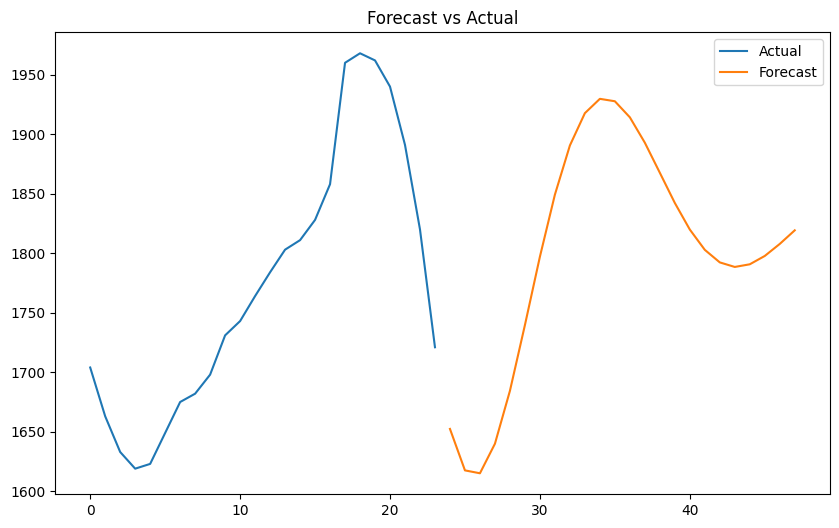

In [27]:
import matplotlib.pyplot as plt

# Create a figure to visualize the comparison of actual values and forecasted values
plt.figure(figsize=(10, 6)) # Set the figure size for better readability

# Plot the actual values with their corresponding indices
plt.plot(range(len(actual_values)), actual_values, label='Actual') # Actual values

# Plot the forecasted values, starting from the end of the actual values
plt.plot(range(len(actual_values), len(actual_values) + len(predictions)), predictions, label='Forecast')  # Forecasted values

# Add a legend to distinguish between actual and forecasted values
plt.legend()

# Add a title for context
plt.title('Forecast vs Actual')

# Display the plot
plt.show()
